In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

/work/mmarcheg/miniconda3/envs/pocket-coffea-blank/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=400000).events()

In [3]:
events.Jet.rawFactor

<Array [[0.0635, 0.04, ... -0.00543, -0.664]] type='400000 * var * float32[param...'>

In [4]:
SF = ak.flatten(1 - events.Jet.rawFactor)
SF

<Array [0.937, 0.96, 0.958, ... 1.01, 1.66] type='4343693 * float32'>

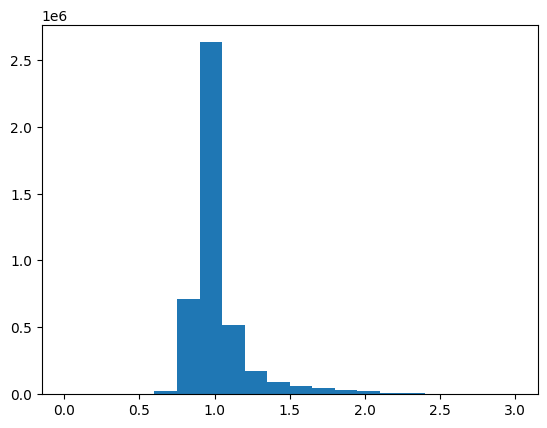

In [5]:
plt.hist(SF, bins=20, range=(0,3));

In [6]:
pt_raw = (1 - events.Jet['rawFactor']) * events.Jet['pt']

In [7]:
ratio = ak.flatten(events.Jet.pt/pt_raw)
ratio

<Array [1.07, 1.04, 1.04, ... 0.995, 0.601] type='4343693 * float32'>

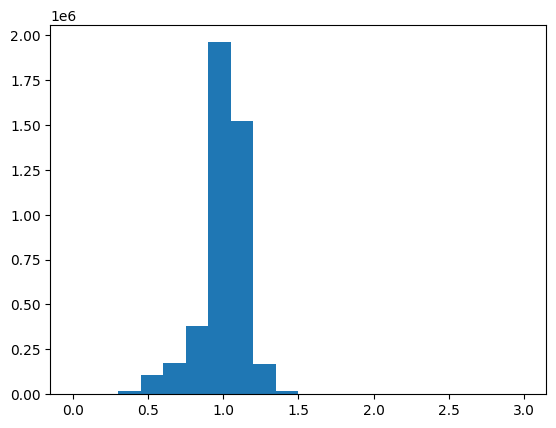

In [8]:
plt.hist(ratio, bins=20, range=(0,3));

(array([0.000000e+00, 0.000000e+00, 0.000000e+00, 2.050000e+02,
        2.136400e+04, 7.107010e+05, 2.630348e+06, 5.204000e+05,
        1.720750e+05, 9.079700e+04, 6.480300e+04, 4.666500e+04,
        3.338600e+04, 2.284300e+04, 1.320600e+04, 8.632000e+03,
        4.469000e+03, 1.948000e+03, 1.068000e+03, 5.150000e+02]),
 array([0.        , 0.15000001, 0.30000001, 0.44999999, 0.60000002,
        0.75      , 0.89999998, 1.04999995, 1.20000005, 1.35000002,
        1.5       , 1.64999998, 1.79999995, 1.95000005, 2.0999999 ,
        2.25      , 2.4000001 , 2.54999995, 2.70000005, 2.8499999 ,
        3.        ]),
 <BarContainer object of 20 artists>)

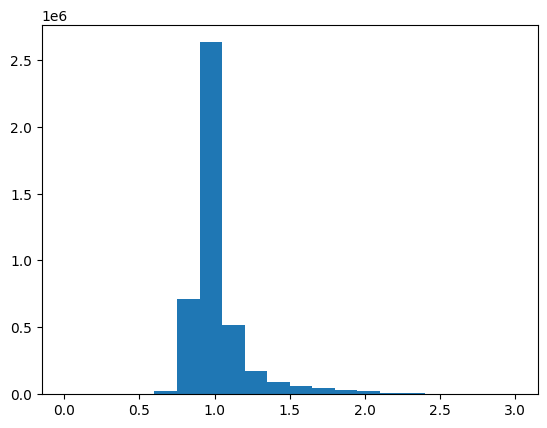

In [9]:
plt.hist(1/ratio, bins=20, range=(0,3))

# Testing the coffea implementation

In [10]:
import gzip

import cloudpickle

In [11]:
path = "../pocket_coffea/parameters/jec/jets_evaluator_NOJES.pkl.gz"

In [12]:
with gzip.open(path) as fin:
        jmestuff = cloudpickle.load(fin)

In [13]:
def add_jec_variables(jets, event_rho):
    jets["pt_raw"] = (1 - jets.rawFactor)*jets.pt
    jets["mass_raw"] = (1 - jets.rawFactor)*jets.mass
    jets["pt_gen"] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
    jets["event_rho"] = ak.broadcast_arrays(event_rho, jets.pt)[0]
    return jets


In [14]:
import cachetools
jec_cache = cachetools.Cache(np.inf)

In [15]:
%%time
j = jmestuff["jet_factory"]["2018"].build(add_jec_variables(events.Jet,events.fixedGridRhoFastjetAll), jec_cache)
jr = jmestuff["jet_factory"]["2018_NOJES"].build(add_jec_variables(events.Jet,events.fixedGridRhoFastjetAll), jec_cache)

CPU times: user 4.51 s, sys: 1.19 s, total: 5.71 s
Wall time: 5.72 s


In [16]:
[f for f in jr.fields if "JER" in f]

['JER']

In [17]:
[f for f in jr.fields if "JES" in f]

[]

In [18]:
%%time
j.JES_HF_2018.up.pt

CPU times: user 1.32 ms, sys: 280 µs, total: 1.6 ms
Wall time: 1.63 ms


<Array [[178, 94, 75.9, ... 22.2, 25, 23.4]] type='400000 * var * float32'>

In [19]:
j.JER.fields

['up', 'down']

Text(0.5, 0, 'Jets pt')

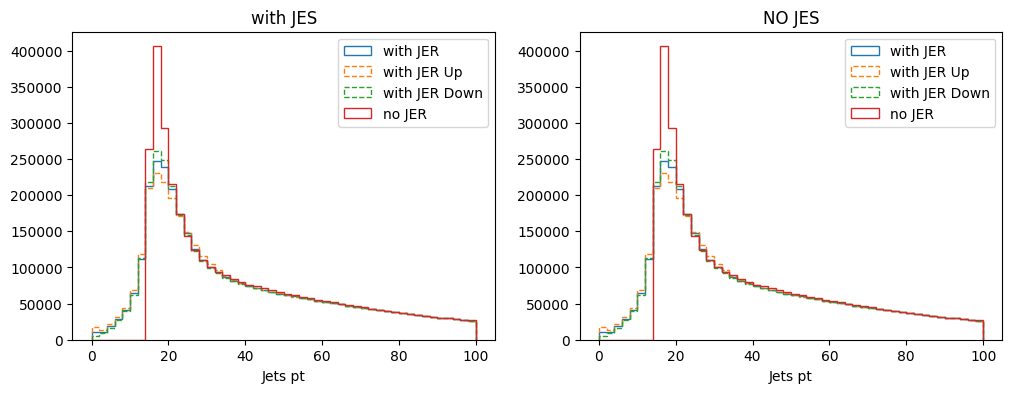

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])
ax1.hist(ak.flatten(j.pt), bins=50, range=(0,100), histtype="step", label="with JER")
ax1.hist(ak.flatten(j.JER.up.pt), bins=50, range=(0,100), histtype="step", label="with JER Up", linestyle='dashed')
ax1.hist(ak.flatten(j.JER.down.pt), bins=50, range=(0,100), histtype="step", label="with JER Down", linestyle='dashed')
ax1.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step",label="no JER")
ax1.legend()
ax1.set_title("with JES")
ax1.set_xlabel("Jets pt")

ax2.hist(ak.flatten(jr.pt), bins=50, range=(0,100), histtype="step", label="with JER")
ax2.hist(ak.flatten(jr.JER.up.pt), bins=50, range=(0,100), histtype="step", label="with JER Up", linestyle='dashed')
ax2.hist(ak.flatten(jr.JER.down.pt), bins=50, range=(0,100), histtype="step", label="with JER Down", linestyle='dashed')
ax2.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step",label="no JER")
ax2.legend()
ax2.set_title("NO JES")
ax2.set_xlabel("Jets pt")

(array([ 11039.,  13818.,  24235.,  36152.,  49853.,  78287., 149886.,
        247230., 255970., 229251., 192016., 160199., 136065., 118373.,
        106003.,  97323.,  90028.,  84248.,  80024.,  76970.,  73153.,
         70420.,  68014.,  65194.,  62913.,  61074.,  58959.,  57185.,
         55294.,  53046.,  51664.,  49842.,  47987.,  46388.,  45223.,
         43309.,  41689.,  40407.,  38796.,  37766.,  36062.,  34896.,
         34008.,  32544.,  31003.,  29933.,  29405.,  27789.,  26699.,
         25998.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7fd19cd81f70>])

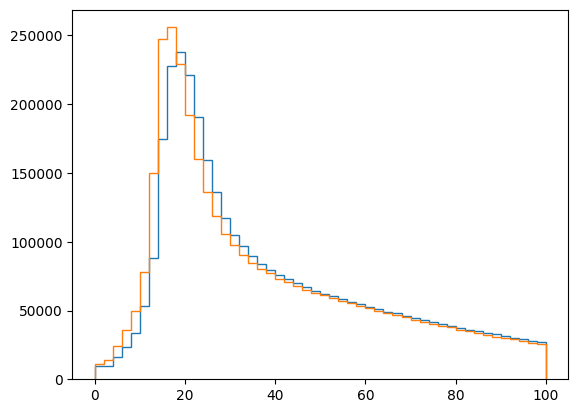

In [21]:
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(j.JES_jes.down.pt), bins=50, range=(0,100), histtype="step")

(array([  9419.,   9520.,  15891.,  23578.,  33505.,  53124.,  88488.,
        175039., 227541., 237822., 221191., 190696., 159588., 135980.,
        117390., 104570.,  96696.,  89866.,  83739.,  79227.,  75878.,
         72617.,  69942.,  66763.,  64502.,  62184.,  60499.,  58119.,
         56514.,  54766.,  52686.,  51045.,  49051.,  47998.,  46238.,
         44772.,  43138.,  41647.,  40153.,  38745.,  37402.,  36196.,
         34923.,  33923.,  32695.,  31263.,  30054.,  29398.,  27819.,
         27141.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7fd196ebd5e0>])

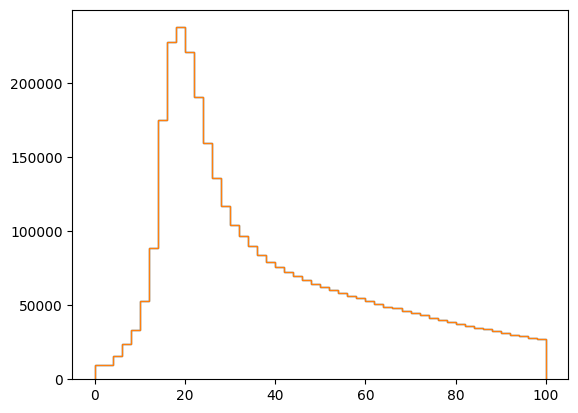

In [22]:
plt.hist(ak.flatten(j.JES_Total.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")

In [23]:
events["Jet"] = j.JES_jes.up

(array([  9419.,   9520.,  15891.,  23578.,  33505.,  53124.,  88488.,
        175039., 227541., 237822., 221191., 190696., 159588., 135980.,
        117390., 104570.,  96696.,  89866.,  83739.,  79227.,  75878.,
         72617.,  69942.,  66763.,  64502.,  62184.,  60499.,  58119.,
         56514.,  54766.,  52686.,  51045.,  49051.,  47998.,  46238.,
         44772.,  43138.,  41647.,  40153.,  38745.,  37402.,  36196.,
         34923.,  33923.,  32695.,  31263.,  30054.,  29398.,  27819.,
         27141.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 [<matplotlib.patches.Polygon at 0x7fd196c0b1c0>])

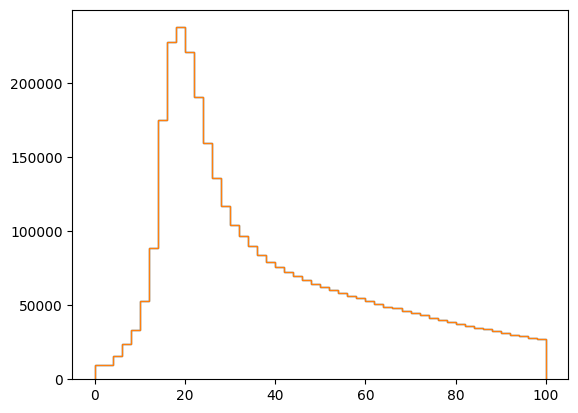

In [24]:
plt.hist(ak.flatten(j.JES_jes.up.pt), bins=50, range=(0,100), histtype="step")
plt.hist(ak.flatten(events.Jet.pt), bins=50, range=(0,100), histtype="step")

# PocketCoffea test

In [25]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from coffea.util import load
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep

from coffea.util import load
from coffea.hist import plot
import numpy as np
import pandas as pd

from pprint import pprint 
hep.style.use(hep.style.ROOT)

In [26]:
from coffea.util import load
df = load("../output/test_shape_variations_v23/output.coffea")

FileNotFoundError: [Errno 2] No such file or directory: '../output/test_shape_variations_v23/output.coffea'

In [ ]:
H = df["variables"]["JetGood_pt_1"]["ttHTobb"]
H

In [ ]:
hep.histplot(H[{"variation":"JES_jesUp", "cat":"baseline", "year":"2018"}], label="U")
hep.histplot(H[{"variation":"JES_jesDown", "cat":"baseline", "year":"2018"}], label="D")
plt.legend()
plt.yscale("log")

In [ ]:
shapes = [
    ('ttHTobb', 'baseline', '2018', "no btag SF"),
    ('ttHTobb', 'btagSF', '2018', "btag SF"),
]
hist_comparison(output, "hist_muon_pt", shapes, ylog=True)